# CNN Inference and Test Set Metric Calculation

## Setup

In [1]:
import sys
import warnings

sys.path.append("../../")
warnings.filterwarnings("ignore")

# set working directory to root 
import os
os.chdir("../../")
root = os.getcwd()
root = root + "/workspaces/mine-segmentation" # for lightning studios
root

'/teamspace/studios/this_studio/workspaces/mine-segmentation'

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
import leafmap
import torch
import torch.nn.functional as F
from einops import rearrange
from matplotlib.colors import ListedColormap
from sklearn.metrics import jaccard_score, f1_score, accuracy_score, recall_score, precision_score, roc_auc_score
from tqdm import tqdm
import matplotlib.pyplot as plt
import contextily as ctx
from shapely.wkt import loads
import datetime
from pathlib import Path
import random

from src.models.datamodule import MineDataModule
from src.models.cnn.model import MineSegmentorCNN

from src.visualization.visualization_funcs import plot_pred_vs_true_mask

In [3]:
# for development
%load_ext autoreload
%autoreload 2

### Define paths and parameters

In [4]:
# 1024 model
MINESEG_CHECKPOINT_PATH = ("models/cnn/mineseg-cnn_epoch-07_val-iou-0.5315.ckpt")
CHIP_SIZE = 1024
TESTSET_BATCH_SIZE = 8
TRAIN_CHIP_DIR = "data/processed/chips/npy/1024/train/chips/"
TRAIN_LABEL_DIR = " data/processed/chips/npy/1024/train/labels/"
VAL_CHIP_DIR = "data/processed/chips/npy/1024/val/chips/"
VAL_LABEL_DIR = "data/processed/chips/npy/1024/val/labels/"
TEST_CHIP_DIR = "data/processed/chips/npy/1024/test/chips/"
TEST_LABEL_DIR = "data/processed/chips/npy/1024/test/labels/"

# # 512 model
# MINESEG_CHECKPOINT_PATH = ("models/cnn/mineseg-cnn_epoch-05_val-iou-0.5553.ckpt")
# CHIP_SIZE = 512
# TESTSET_BATCH_SIZE = 64
# TRAIN_CHIP_DIR = "data/processed/chips/npy/512/train/chips/"
# TRAIN_LABEL_DIR = "data/processed/chips/npy/512/train/labels/"
# VAL_CHIP_DIR = "data/processed/chips/npy/512/val/chips/"
# VAL_LABEL_DIR = "data/processed/chips/npy/512/val/labels/"
# TEST_CHIP_DIR = "data/processed/chips/npy/512/test/chips/"
# TEST_LABEL_DIR = "data/processed/chips/npy/512/test/labels/"


DATASET = "/data/processed/mining_tiles_with_masks_and_bounding_boxes.gpkg"
METADATA_PATH = "configs/cnn/cnn_segment_metadata.yaml"
BATCH_SIZE = 1
if torch.cuda.is_available():
    NUM_WORKERS = 16
else:
    NUM_WORKERS = 4
PLATFORM = "sentinel-2-l2a"

In [5]:
is_lightning = True
if is_lightning:
    MINESEG_CHECKPOINT_PATH = root + "/" + MINESEG_CHECKPOINT_PATH
    METADATA_PATH = root + "/" + METADATA_PATH
    TRAIN_CHIP_DIR = root +  "/" +TRAIN_CHIP_DIR
    TRAIN_LABEL_DIR = root + "/" + TRAIN_LABEL_DIR
    VAL_CHIP_DIR = root + "/" + VAL_CHIP_DIR
    VAL_LABEL_DIR = root + "/" + VAL_LABEL_DIR
    TEST_CHIP_DIR = root + "/" + TEST_CHIP_DIR
    TEST_LABEL_DIR = root + "/" + TEST_LABEL_DIR
    DATASET = root + "/" + DATASET
    # print(f"Using model at {MINESEG_CHECKPOINT_PATH}")

In [6]:
model_name = MINESEG_CHECKPOINT_PATH.split("/")[-1]
print(f"Using model {model_name}")
print(f"Using chip size {CHIP_SIZE}")
print(f"Using test chip dir {TEST_CHIP_DIR}")
print(f"Using test label dir {TEST_LABEL_DIR}")

Using model mineseg-cnn_epoch-07_val-iou-0.5315.ckpt
Using chip size 1024
Using test chip dir /teamspace/studios/this_studio/workspaces/mine-segmentation/data/processed/chips/npy/1024/test/chips/
Using test label dir /teamspace/studios/this_studio/workspaces/mine-segmentation/data/processed/chips/npy/1024/test/labels/


### Model Loading

In [7]:
def get_model(checkpoint_path: str) -> MineSegmentorCNN:
    # check if gpu is available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    map_location=torch.device(device)
    checkpoint = torch.load(checkpoint_path, map_location=map_location)
    model_config = checkpoint["hyper_parameters"]
    model = MineSegmentorCNN.load_from_checkpoint(checkpoint_path, **model_config)
    model.eval()
    return model

### Data Preparation

In [8]:
def get_data(
    train_chip_dir,
    train_label_dir,
    val_chip_dir,
    val_label_dir,
    test_chip_dir,
    test_label_dir,
    metadata_path,
    batch_size,
    num_workers,
    platform,
    data_augmentation,
    index=None
):
    dm = MineDataModule(
        train_chip_dir=train_chip_dir,
        train_label_dir=train_label_dir,
        val_chip_dir=val_chip_dir,
        val_label_dir=val_label_dir,
        test_chip_dir=test_chip_dir,
        test_label_dir=test_label_dir,
        metadata_path=metadata_path,
        batch_size=batch_size,
        num_workers=num_workers,
        platform=platform,
        data_augmentation=data_augmentation,
    )
    
    dm.setup(stage="test")
    
    if index is not None:
        test_dl = iter(dm.test_dataloader())
        for i in range(index + 1):
            batch = next(test_dl)
        metadata = dm.metadata
        return batch, metadata
    else:
        test_dl = dm.test_dataloader()
        batch = next(iter(test_dl))
        metadata = dm.metadata
        return batch, metadata
    metadata = dm.metadata
    return batch, metadata

### Prediction

In [9]:
def run_prediction(model, batch):
    with torch.no_grad():
        image = batch["pixels"]
        outputs = model(image)
    outputs = F.interpolate(
        outputs, size=(CHIP_SIZE, CHIP_SIZE), mode="bilinear", align_corners=False
    )
    return outputs

### Post-Processing

In [10]:
def post_process(batch, outputs, metadata):
    prob_mask = outputs.cpu().numpy()
    pred_mask = (prob_mask > 0.5).astype(float)
    labels = batch["label"].detach().cpu().numpy()
    pixels = batch["pixels"].detach().cpu().numpy()

    # normalize and clip the image ranges
    pixels = (pixels - pixels.min()) / (pixels.max() - pixels.min())
    pixels = np.clip(pixels, 0, 1)

    images = pixels[0]
    labels = labels[0]
    prob_mask = prob_mask[0]
    pred_mask = pred_mask[0].astype(float)

    images = images.transpose((1,2,0))
    prob_mask = prob_mask.transpose((1,2,0))
    pred_mask = pred_mask.transpose((1,2,0)).astype(float)

    return images, labels, prob_mask, pred_mask

### Plotting

In [11]:
def plot_predictions(images, labels, probas, preds):
    fig, axes = plt.subplots(1, 5, figsize=(15, 6))

    # Plot the image
    axes[0].imshow(images)
    axes[0].axis("off")
    axes[0].set_title("Image", fontsize=12)

    # Plot the actual segmentation
    axes[1].imshow(labels, vmin=0, vmax=1)
    axes[1].axis("off")
    axes[1].set_title("Actual", fontsize=12)

    # Plot the predicted segmentation
    axes[2].imshow(preds, vmin=0, vmax=1)
    axes[2].axis("off")
    axes[2].set_title("Pred", fontsize=12)

    # Plot the predicted segmentation
    axes[3].imshow(probas, vmin=0, vmax=1)
    axes[3].axis("off")
    axes[3].set_title("Proba", fontsize=12)

    # Plot the plot_pred_vs_true_mask
    plot_pred_vs_true_mask(images, labels, preds.squeeze(), ax=axes[4], add_legend=False)
    axes[4].set_title("Pred vs True", fontsize=12)

    plt.tight_layout()
    plt.show()

In [12]:
# Load model
model = get_model(MINESEG_CHECKPOINT_PATH)

Using device: cpu


## Plot example predictions

7 Random chips, including their ground truth and predicted masks

In [13]:
test_chips = os.listdir(TEST_CHIP_DIR)
test_chips_wo_miningarea = [chip for chip in test_chips if "nominearea" in chip]
test_chips_w_miningarea = [chip for chip in test_chips if "nominearea" not in chip]
indices_wo_miningarea = [test_chips.index(chip) for chip in test_chips_wo_miningarea]
indices_w_miningarea = [test_chips.index(chip) for chip in test_chips_w_miningarea]

print(f"Number of test chips: {len(test_chips)}")
print(f"Number of test chips without mining area: {len(test_chips_wo_miningarea)}")
print(f"Number of test chips with mining area: {len(test_chips_w_miningarea)}")

# take a sample of the chips with mining area 
random.seed(42)
sample_indices_w_ma = random.sample(indices_w_miningarea, 4)
print(f"Sample indices of chips with mining area: {sample_indices_w_ma}")

sample_indices_wo_ma = random.sample(indices_wo_miningarea, 4)
print(f"Sample indices of chips without mining area: {sample_indices_wo_ma}")

Number of test chips: 336
Number of test chips without mining area: 145
Number of test chips with mining area: 191
Sample indices of chips with mining area: [281, 48, 10, 334]
Sample indices of chips without mining area: [157, 137, 126, 84]


In [14]:
def plot_sample_predictions(sample_indices):
    for index in sample_indices:

        # Get data
        batch, metadata = get_data(
            TRAIN_CHIP_DIR,
            TRAIN_LABEL_DIR,
            VAL_CHIP_DIR,
            VAL_LABEL_DIR,
            TEST_CHIP_DIR,
            TEST_LABEL_DIR,
            METADATA_PATH,
            BATCH_SIZE,
            NUM_WORKERS,
            PLATFORM,
            data_augmentation=False,
            index=index
        )

        # Move batch to GPU
        if torch.cuda.is_available():
            batch = {k: v.to("cuda") for k, v in batch.items()}

        # Run prediction
        outputs = run_prediction(model, batch)

        # Post-process the results
        images, labels, probas, preds = post_process(batch, outputs, metadata)

        # Plot the predictions
        plot_predictions(images, labels, probas, preds)
   

Predictions on chips with mining area: 

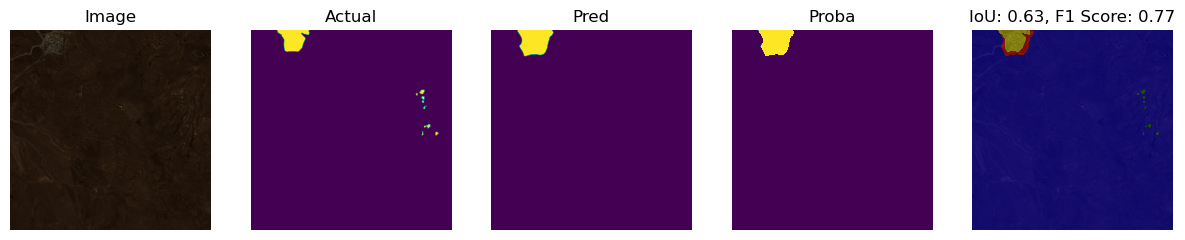

<Figure size 640x480 with 0 Axes>

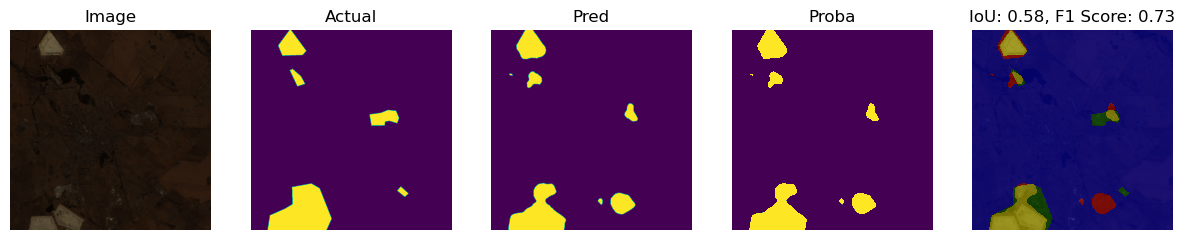

<Figure size 640x480 with 0 Axes>

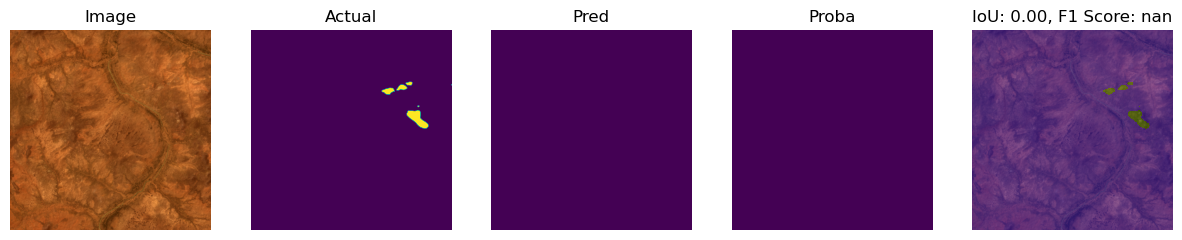

<Figure size 640x480 with 0 Axes>

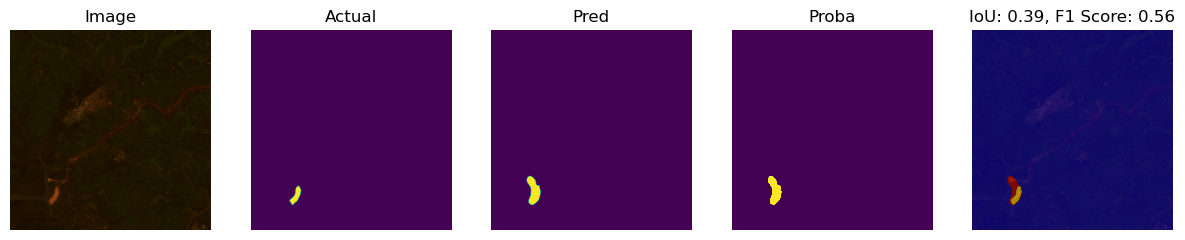

<Figure size 640x480 with 0 Axes>

In [15]:
plot_sample_predictions(sample_indices_w_ma)

Predictions on chips without mining area:

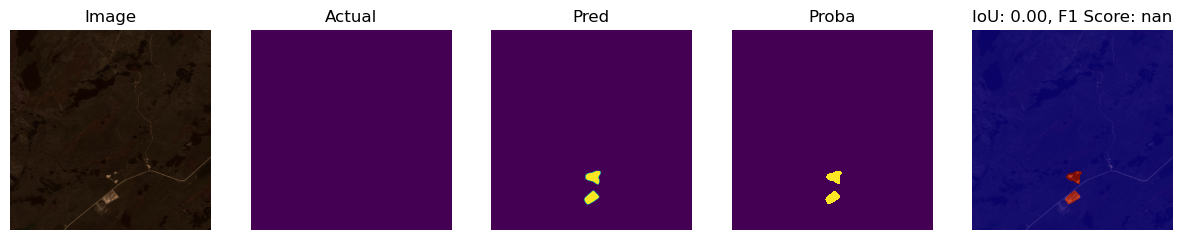

<Figure size 640x480 with 0 Axes>

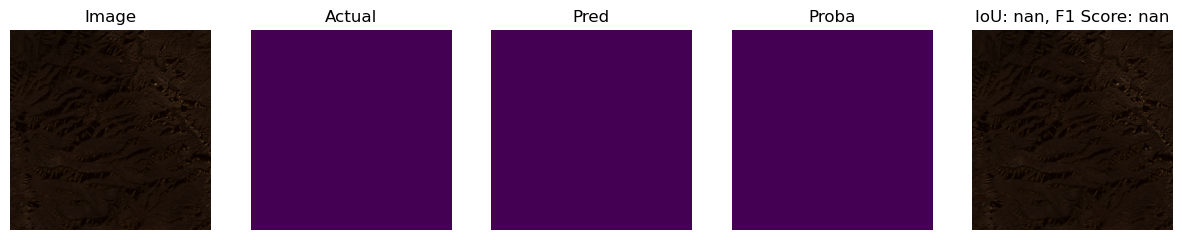

<Figure size 640x480 with 0 Axes>

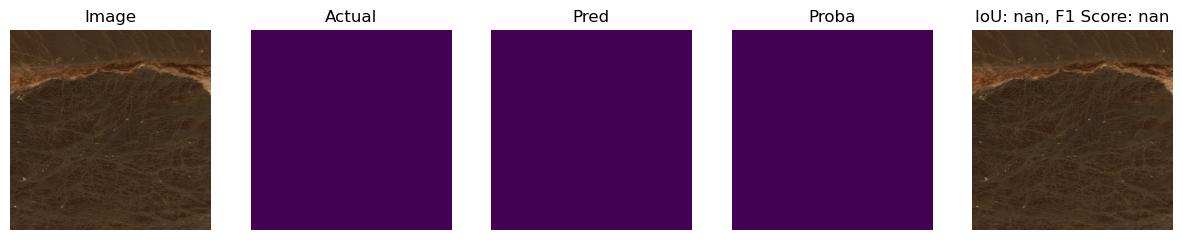

<Figure size 640x480 with 0 Axes>

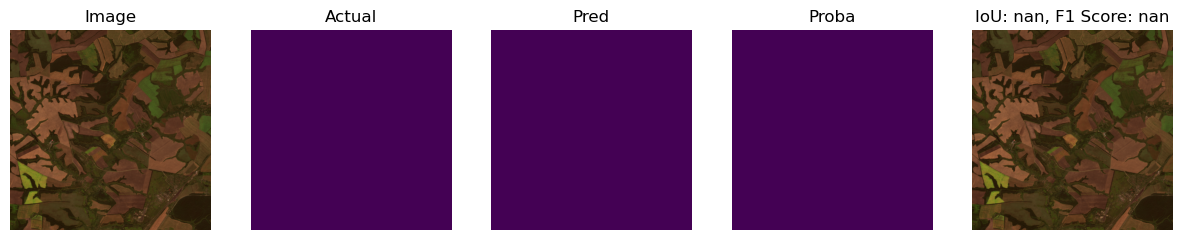

<Figure size 640x480 with 0 Axes>

In [16]:
plot_sample_predictions(sample_indices_wo_ma)

In [17]:
# fig = plot_pred_vs_true_mask(images, labels, preds.squeeze(), ax=None)

## Metric calculation on test dataset

To calculate the metric on the test dataset, we need to predict the masks for all the chips in the test dataset and then calculate an aggregate metric.


By default, the test set includes only chips with mining area. However, this will cover differently large areas of the actual tiles. Therefore, we will also calculate the metric on the full test set, which includes all chips from the test tiles. This makes models for different chip sizes comparable.

### Define Functions

In [13]:
def calculate_metrics(model, test_chips, testset_batch_size):
    """
    Calculates various metrics for evaluating the performance of a model on a test dataset.

    Args:
        model (torch.nn.Module): The model to evaluate.
        test_chips (list): A list of test chip file names.
        testset_batch_size (int): The batch size for processing the test dataset.

    Returns:
        pandas.DataFrame: A DataFrame containing the calculated metrics for each image in the test dataset.
            The DataFrame has the following columns: 'image', 'file_name', 'iou', 'f1', 'accuracy', 'recall', 'precision'.
    """

    # Initialize a DataFrame to store the results
    results = pd.DataFrame(columns=['image', "file_name", 'iou', 'f1', 'accuracy', 'recall', 'precision'])

    # Calculate number of batches
    num_batches = int(np.ceil(len(test_chips) / testset_batch_size))

    # Move model to GPU
    if torch.cuda.is_available():
        model = model.to("cuda")

    for i in tqdm(range(num_batches)):

        file_names = test_chips[i * testset_batch_size : (i + 1) * testset_batch_size]

        # Get data
        batch, metadata = get_data(
            TRAIN_CHIP_DIR,
            TRAIN_LABEL_DIR,
            VAL_CHIP_DIR,
            VAL_LABEL_DIR,
            TEST_CHIP_DIR,
            TEST_LABEL_DIR,
            METADATA_PATH,
            testset_batch_size,
            NUM_WORKERS,
            PLATFORM,
            data_augmentation=False,
            index=i  # Get the next batch of images
        )

        # Move batch to GPU
        if torch.cuda.is_available():
            batch = {k: v.to("cuda") for k, v in batch.items()}

        # Run prediction
        outputs = run_prediction(model, batch)

        labels = batch["label"].detach().cpu().numpy()
        preds = outputs.detach().cpu().numpy()
        preds = (preds > 0.5).astype(float)

        # Calculate the metrics for each image in the batch
        for j in range(len(outputs)):
            iou = jaccard_score(labels[j].flatten(), preds[j].flatten())
            f1 = f1_score(labels[j].flatten(), preds[j].flatten())
            accuracy = accuracy_score(labels[j].flatten(), preds[j].flatten())
            recall = recall_score(labels[j].flatten(), preds[j].flatten())
            precision = precision_score(labels[j].flatten(), preds[j].flatten())

            # Add the results to the DataFrame
            results = pd.concat(
                [results, 
                pd.DataFrame(
                    {
                        'image': [i * testset_batch_size + j], 
                        'file_name': [file_names[j]],
                        'iou': [iou], 
                        'f1': [f1], 
                        'accuracy': [accuracy], 
                        'recall': [recall], 
                        'precision': [precision]
                    })])

    return results

In [14]:
def calculate_metrics_and_save(results, output_dir):
    # load the processed dataset
    tiles = gpd.read_file(DATASET, layer="tiles")
    test_tiles = tiles[tiles["split"] == "test"]

    # extract the tile_id from the file_name
    results["tile_id"] = results["file_name"].apply(lambda x: x.split("_")[0])

    # save as csv in the reports folder
    output_path = output_dir + "/testset_metrics_per_chip.csv"
    results.to_csv(output_path, index=False)
    print(f"Saved per chip metrics to {output_path}")

    # Select only the numeric columns
    numeric_columns = results.select_dtypes(include=['float64', 'int64'])

    # Add the 'tile_id' column to the numeric columns
    numeric_columns['tile_id'] = results['tile_id']

    # Group by 'tile_id' and calculate the mean of the numeric columns
    results_grouped = numeric_columns.groupby('tile_id').mean().reset_index()

    # Merge the results with the test_tiles
    test_tiles = test_tiles.merge(results_grouped, on='tile_id')

    # save as csv in the reports folder
    output_path = output_dir + "/testset_metrics_aggregated.csv"
    test_tiles.to_csv(output_path, index=False)
    print(f"Saved aggregated metrics to {output_path}")

    # calculate overall metrics
    iou = results_grouped["iou"].mean()
    f1 = results_grouped["f1"].mean()
    accuracy = results_grouped["accuracy"].mean()
    recall = results_grouped["recall"].mean()
    precision = results_grouped["precision"].mean()

    # print the results
    print(f"Mean IoU: {iou}")
    print(f"Mean F1: {f1}")
    print(f"Mean Accuracy: {accuracy}")
    print(f"Mean Recall: {recall}")
    print(f"Mean Precision: {precision}")

    return results_grouped

In [15]:
def print_grouped_metrics(results_grouped):
    # Metrics per mine type
    print("Metrics per mine type (minetype1):")
    print(results_grouped.groupby("minetype1")[["iou", "f1", "accuracy", "recall", "precision"]].mean())
    print("-----------------------------------------------")

    # Metrics per mine type
    print("Metrics per mine type (minetype2):")
    print(results_grouped.groupby("minetype2")[["iou", "f1", "accuracy", "recall", "precision"]].mean())
    print("-----------------------------------------------")

    # Metrics per dataset
    print("Metrics per dataset (preferred_dataset):")
    print(results_grouped.groupby("preferred_dataset")[["iou", "f1", "accuracy", "recall", "precision"]].mean())
    print("-----------------------------------------------")

    # print a histogram of the iou scores
    print("Histogram of IoU scores:")
    results_grouped["iou"].hist(bins=20)
    plt.show()

In [16]:
def plot_iou_on_test_tiles(results_grouped):
    fig, ax = plt.subplots(1, 1, figsize=(20, 25))

    # Assuming test_tiles is your GeoDataFrame
    results_grouped = results_grouped.set_crs(epsg=4326)

    # Convert the GeoDataFrame to Web Mercator projection (EPSG:3857)
    results_grouped = results_grouped.to_crs(epsg=3857)

    # Buffer the polygons to increase their size
    results_grouped['geometry'] = results_grouped.geometry.buffer(200000)

    # Plot the GeoDataFrame
    results_grouped.plot(column='iou', cmap='RdYlGn', linewidth=0.8, ax=ax, edgecolor='0.8', alpha=1)

    # Add a basemap
    ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

    ax.axis('off')
    ax.set_title('IoU on test tiles', fontdict={'fontsize': '25', 'fontweight' : '3'})

    # Create a colorbar as a legend
    sm = plt.cm.ScalarMappable(cmap='RdYlGn', norm=plt.Normalize(vmin=min(test_tiles['iou']), vmax=max(results_grouped['iou'])))
    sm._A = []
    cbar = fig.colorbar(sm, ax=ax, orientation='horizontal', fraction=0.03, pad=0.04)
    cbar.ax.tick_params(labelsize=8)  # set the size of the colorbar labels

    plt.show()


Create the new directory for the report and the data files

In [17]:
output_dir = root + f"/reports/cnn/{str(CHIP_SIZE) + '_' + ''.join(model_name.split('.')[:-1])}"
Path(output_dir).mkdir(parents=True, exist_ok=True)
print(f"Saving results to {output_dir}")

Saving results to /teamspace/studios/this_studio/workspaces/mine-segmentation/reports/cnn/1024_mineseg-cnn_epoch-07_val-iou-05315


### On the test set chips (mining area chips only)

Define list of chips: 

In [18]:
# list all files in the test chip directory
test_chips = os.listdir(TEST_CHIP_DIR)

# filter out only files that do not contain the string nominearea
test_chips = [chip for chip in test_chips if "nonminearea" not in chip]

In [19]:
### Optional: Load the aggregated metrics that were previously computed and saved. 

# # load the csv file with the aggregated metrics
# test_tiles = pd.read_csv(root + "/reports/cnn_testset_metrics_aggregated_2024-09-06_13.csv")
# test_tiles['geometry'] = test_tiles['geometry'].apply(loads)

# # convert to gdf
# test_tiles = gpd.GeoDataFrame(test_tiles, geometry=test_tiles["geometry"])

Calculate the metrics: 

In [20]:
results = calculate_metrics(model, test_chips, TESTSET_BATCH_SIZE)

  0%|          | 0/42 [00:00<?, ?it/s]

  5%|▍         | 2/42 [02:03<41:12, 61.82s/it]


KeyboardInterrupt: 

Aggregate metrics: 

In [ ]:
results_grouped = calculate_metrics_and_save(results, output_dir)

Grouped metrics: 

In [ ]:
print_grouped_metrics(results_grouped)

IoU per tile on the map: 

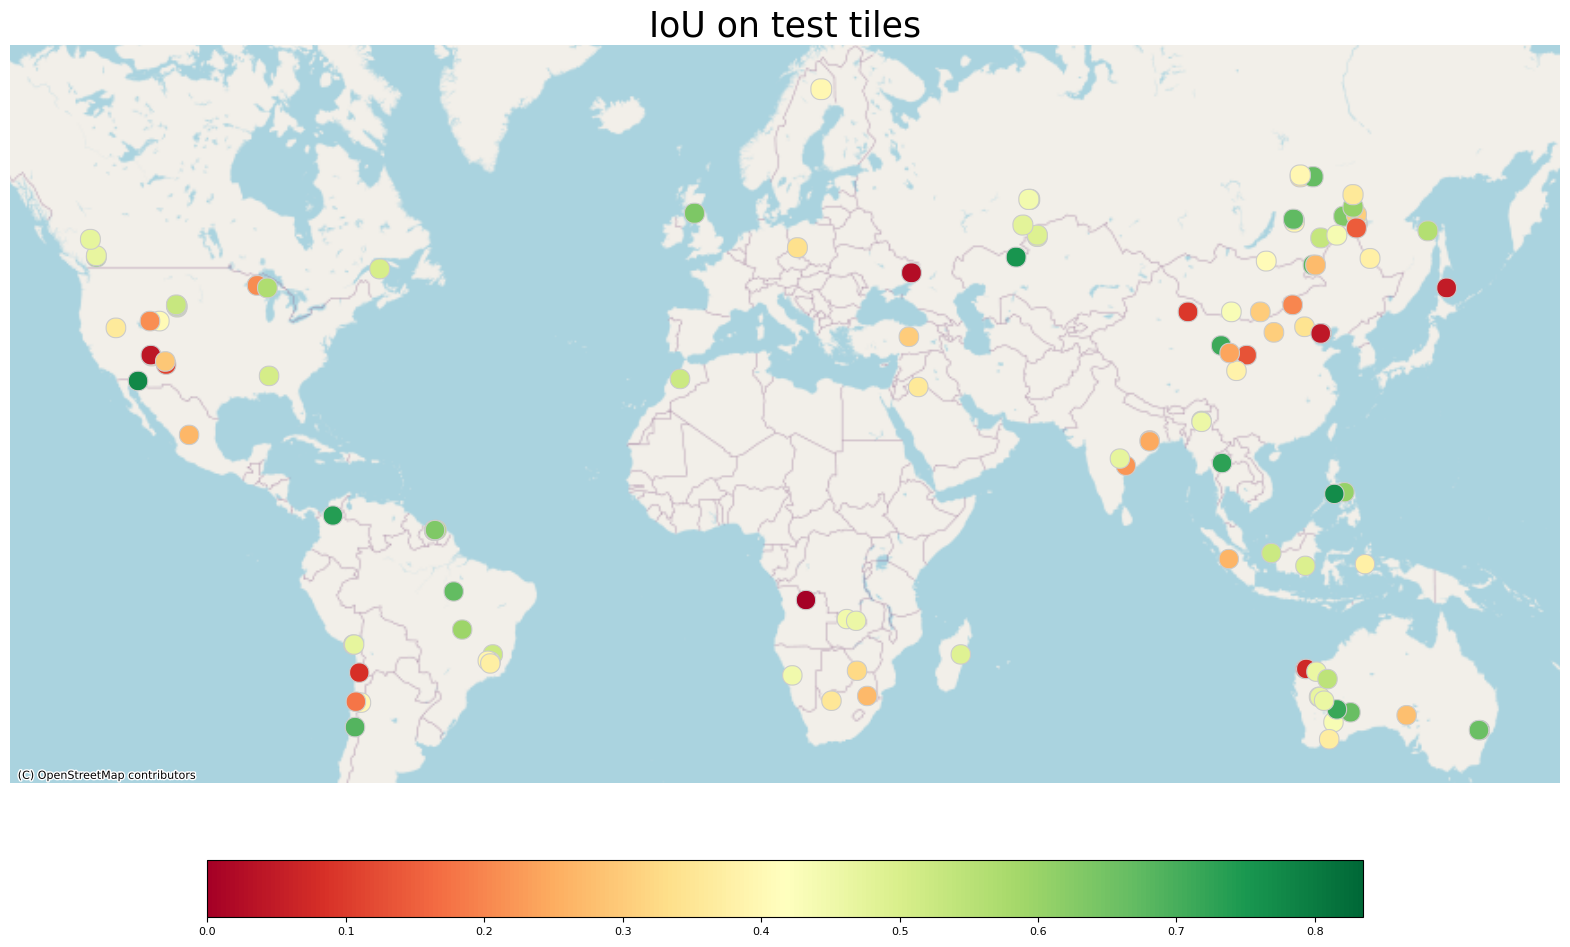

In [41]:
plot_iou_on_test_tiles(results_grouped)

### On the whole test set tile (including chips without mining area)

In [ ]:
# list all files in the test chip directory
test_chips = os.listdir(TEST_CHIP_DIR)

Calculate the metrics: 

In [ ]:
results = calculate_metrics(test_chips, TESTSET_BATCH_SIZE)

Aggregate metrics: 

In [ ]:
results_grouped = calculate_metrics_and_save(results, output_dir)

Grouped metrics: 

In [ ]:
print_grouped_metrics(results_grouped)

IoU per tile on the map: 

In [ ]:
plot_iou_on_test_tiles(results_grouped)

In [ ]:
# list all files in the test chip directory
test_chips = os.listdir(TEST_CHIP_DIR)

In [ ]:
# export the notebook to reports
!jupyter nbconvert --to html "notebooks/cnn/cnn_inference.ipynb" --output-dir="reports/cnn/" --output="CNN_testset_evaluation.html" --no-input --no-prompt